In [4]:
import opendatasets as od
import os
import torch
import timm
import torch.nn as nn
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import os
import random
from sklearn.model_selection import train_test_split

In [5]:
od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: illyawass
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


In [6]:
dataset_path = 'animals10/raw-img'
classes = os.listdir(dataset_path)
print("Класи тварин:", classes)

Класи тварин: ['elefante', 'ragno', 'gallina', 'gatto', 'pecora', 'cavallo', 'scoiattolo', 'mucca', 'farfalla', 'cane']


**Завантаження переднавченої моделі**

In [7]:
model = timm.create_model('xception', pretrained=True)
print("Xception модель успішно завантажено")

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception модель успішно завантажено


**Останній шар замінено на новий з 10ма вихідними класами**


In [47]:
classes = os.listdir(dataset_path)
print("Класи:", classes)
num_classes = len(classes)

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

Класи: ['elefante', 'ragno', 'gallina', 'gatto', 'pecora', 'cavallo', 'scoiattolo', 'mucca', 'farfalla', 'cane']


**Трансформації, і операції над animals-10**

In [50]:
train_transforms = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def split_dataset(root_dir, train_ratio=0.8):
    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    train_files = []
    val_files = []

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        train_subset, val_subset = train_test_split(files, test_size=1-train_ratio, random_state=42)
        train_files.extend([(file, class_dirs.index(class_dir)) for file in train_subset])
        val_files.extend([(file, class_dirs.index(class_dir)) for file in val_subset])

    return train_files, val_files

class AnimalsDataset(torch.utils.data.Dataset):
    def __init__(self, file_labels, transform=None):
        self.file_labels = file_labels
        self.transform = transform

    def __len__(self):
        return len(self.file_labels)

    def __getitem__(self, idx):
        img_path, label = self.file_labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

train_files, val_files = split_dataset(dataset_path)
print("Набори даних:")
print(f"Тренувальний: {len(train_files)}")
print(f"Валідаційний: {len(val_files)}")

train_dataset = AnimalsDataset(train_files, transform=train_transforms)
val_dataset = AnimalsDataset(val_files, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

Набори даних:
Тренувальний: 20938
Валідаційний: 5241


**Розморожування**

In [51]:
for param in model.parameters():
    param.requires_grad = False

def unfreeze_layers(model, layers_to_unfreeze):
    for name, param in model.named_parameters():
        for layer_name in layers_to_unfreeze:
            if layer_name in name:
                param.requires_grad = True
                break

xception_layers = [
    'fc',
    'blocks.11',
    'blocks.10',
    'blocks.9',
    'blocks.8',
    'blocks.7',
    'blocks.6',
    'blocks.5',
    'blocks.4',
    'blocks.3',
    'blocks.2',
    'blocks.1',
    'blocks.0',
    'conv_stem'
]

unfreeze_layers(model, ['fc'])

**Процес тренування моделі з використанням методу перенавчання (fine-tuning), з оновленням ваг моделі**

In [11]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = Adam(params_to_update, lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Епоха {epoch+1}/{num_epochs}')
        print('-' * 10)

        if epoch < len(xception_layers):
            unfreeze_layers(model, [xception_layers[epoch]])
            print(f"Розморожено шар: {xception_layers[epoch]}")

            params_to_update = [p for p in model.parameters() if p.requires_grad]
            optimizer = Adam(params_to_update, lr=0.001)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Втрата: {epoch_loss:.4f} Точність: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'xception_animals10_epoch_{epoch}.pth')

        print()

    time_elapsed = time.time() - since
    print(f'Навчання завершено за {time_elapsed // 60:.0f}хв {time_elapsed % 60:.0f}с')
    print(f'Найкраща точність валідації: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=15)

Епоха 1/15
----------
Розморожено шар: fc
train Втрата: 0.4727 Точність: 0.8709
val Втрата: 0.1178 Точність: 0.9727

Епоха 2/15
----------
Розморожено шар: blocks.11
train Втрата: 0.3145 Точність: 0.9001
val Втрата: 0.1018 Точність: 0.9733

Епоха 3/15
----------
Розморожено шар: blocks.10
train Втрата: 0.3044 Точність: 0.9035
val Втрата: 0.0967 Точність: 0.9754

Епоха 4/15
----------
Розморожено шар: blocks.9
train Втрата: 0.2881 Точність: 0.9076
val Втрата: 0.0926 Точність: 0.9735

Епоха 5/15
----------
Розморожено шар: blocks.8
train Втрата: 0.2909 Точність: 0.9078
val Втрата: 0.0917 Точність: 0.9739

Епоха 6/15
----------
Розморожено шар: blocks.7
train Втрата: 0.2896 Точність: 0.9089
val Втрата: 0.0867 Точність: 0.9744

Епоха 7/15
----------
Розморожено шар: blocks.6
train Втрата: 0.2905 Точність: 0.9075
val Втрата: 0.0973 Точність: 0.9741

Епоха 8/15
----------
Розморожено шар: blocks.5
train Втрата: 0.2871 Точність: 0.9090
val Втрата: 0.0848 Точність: 0.9769

Епоха 9/15
---------

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


F1-скор (weighted): 0.9769


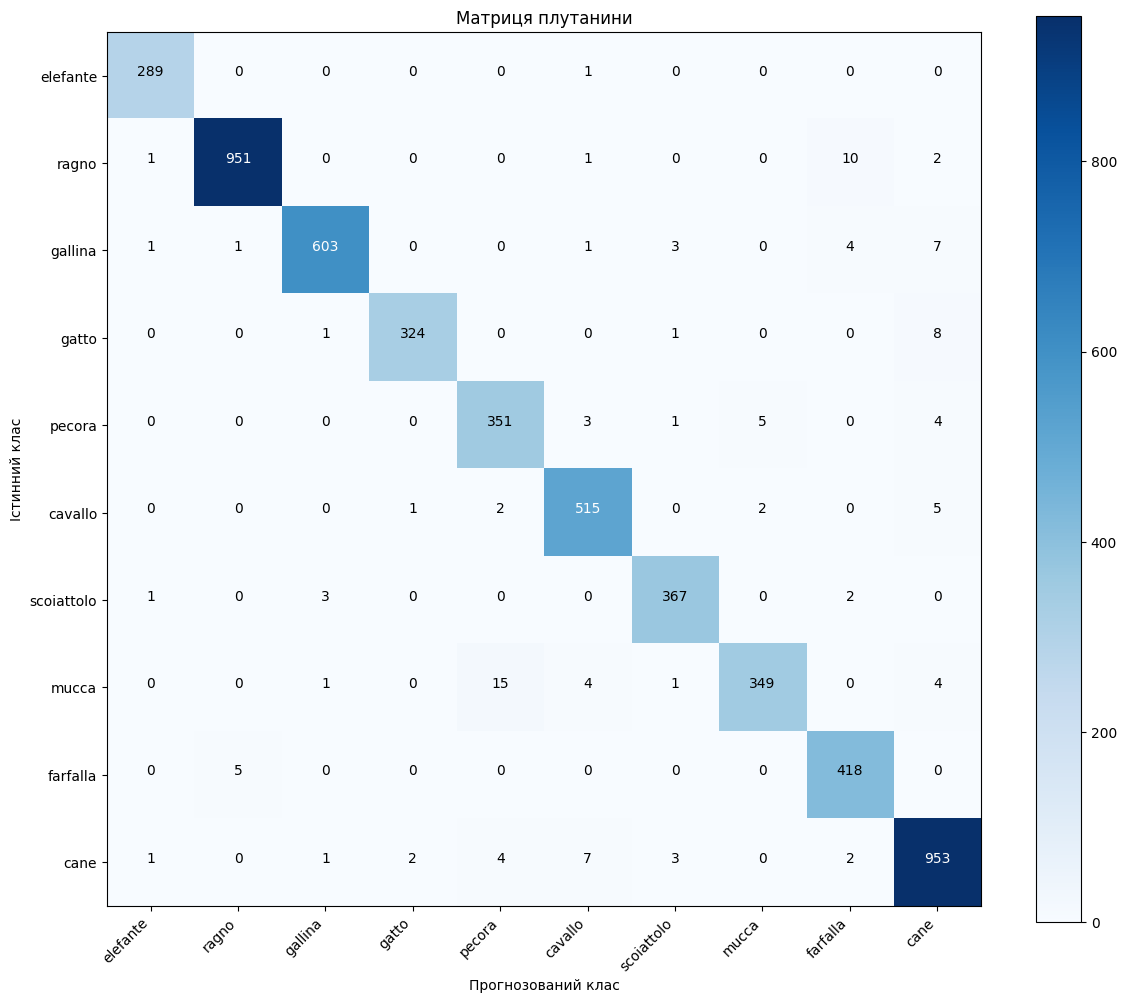


Звіт класифікації:
              precision    recall  f1-score   support

    elefante       0.99      1.00      0.99       290
       ragno       0.99      0.99      0.99       965
     gallina       0.99      0.97      0.98       620
       gatto       0.99      0.97      0.98       334
      pecora       0.94      0.96      0.95       364
     cavallo       0.97      0.98      0.97       525
  scoiattolo       0.98      0.98      0.98       373
       mucca       0.98      0.93      0.96       374
    farfalla       0.96      0.99      0.97       423
        cane       0.97      0.98      0.97       973

    accuracy                           0.98      5241
   macro avg       0.98      0.98      0.98      5241
weighted avg       0.98      0.98      0.98      5241



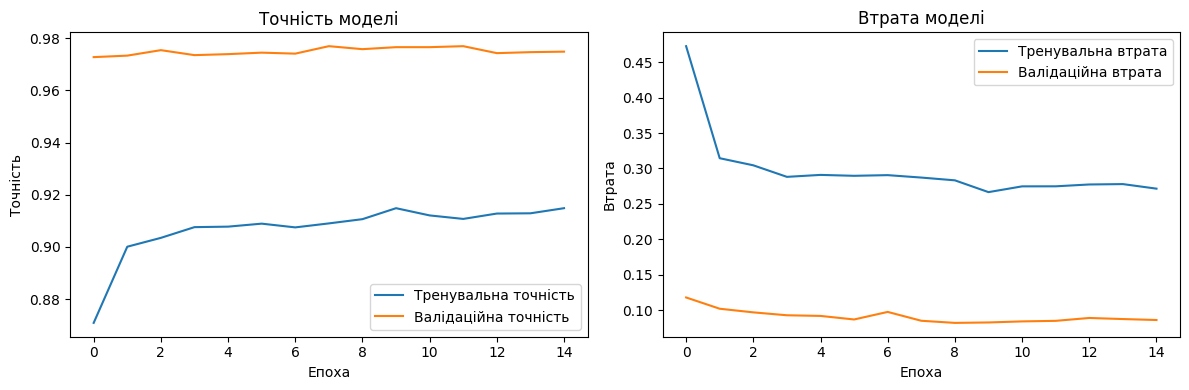

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


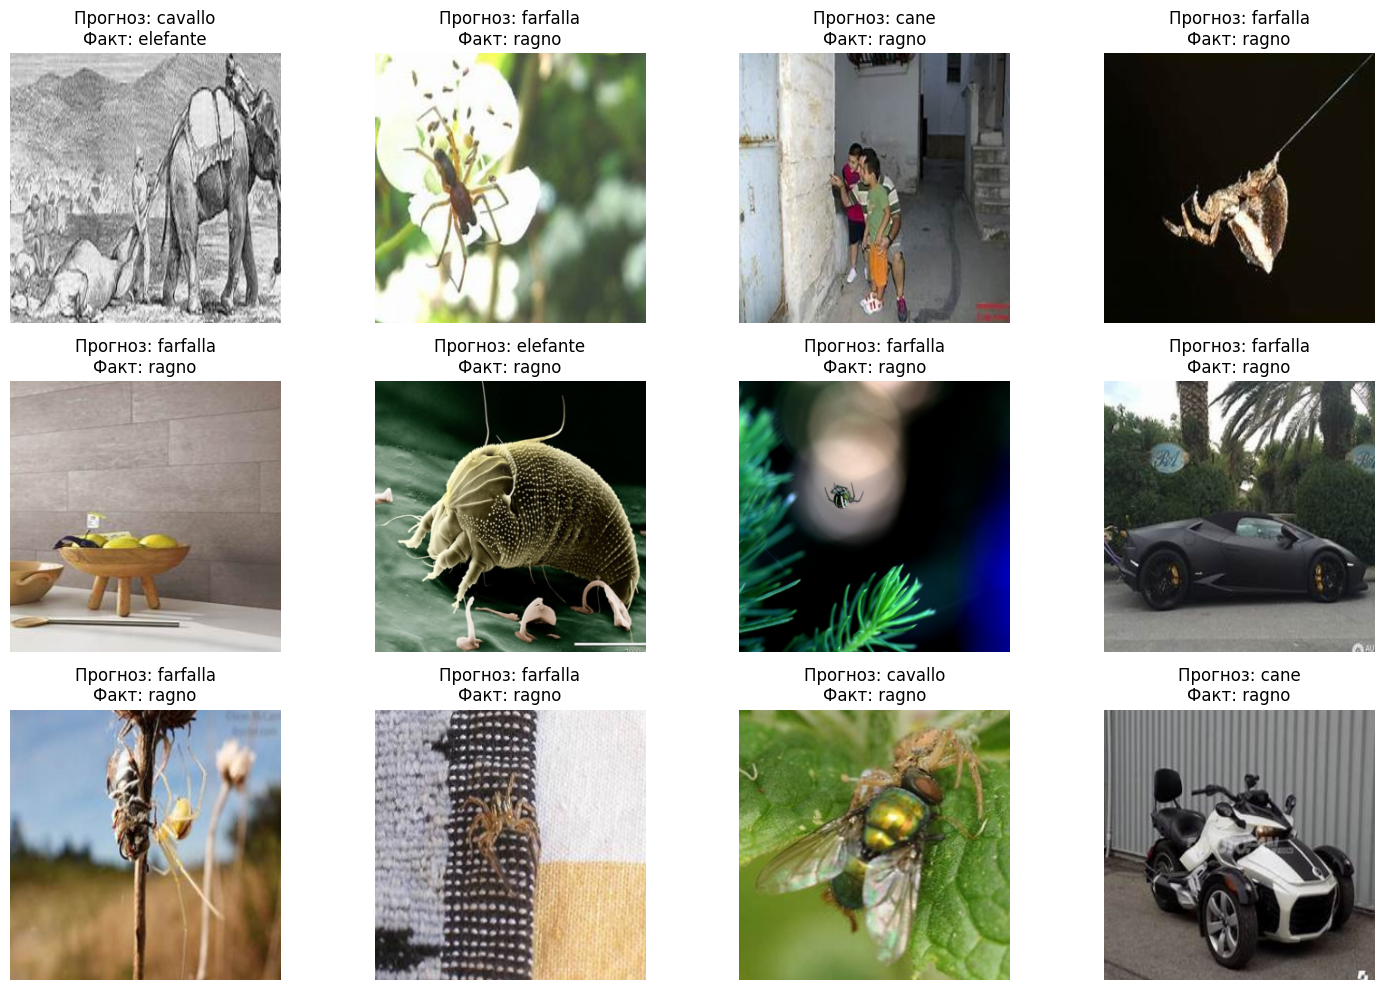

In [14]:
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1-скор (weighted): {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Матриця плутанини')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Істинний клас')
    plt.xlabel('Прогнозований клас')
    plt.savefig('confusion_matrix_animals10.png')
    plt.show()

    print("\nЗвіт класифікації:")
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    with open('classification_report_animals10.txt', 'w') as f:
        f.write(report)

    return all_preds, all_labels

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Тренувальна точність')
    plt.plot(history['val_acc'], label='Валідаційна точність')
    plt.title('Точність моделі')
    plt.xlabel('Епоха')
    plt.ylabel('Точність')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Тренувальна втрата')
    plt.plot(history['val_loss'], label='Валідаційна втрата')
    plt.title('Втрата моделі')
    plt.xlabel('Епоха')
    plt.ylabel('Втрата')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history_animals10.png')
    plt.show()

def visualize_incorrect_predictions(model, dataloader, class_names, device, num_images=10):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu().numpy())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(preds[i].item())

                    if len(misclassified_images) >= num_images:
                        break

            if len(misclassified_images) >= num_images:
                break

    fig = plt.figure(figsize=(15, 10))
    for i in range(min(len(misclassified_images), num_images)):
        ax = fig.add_subplot(3, 4, i + 1)

        img = np.transpose(misclassified_images[i], (1, 2, 0))
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"Прогноз: {class_names[misclassified_preds[i]]}\nФакт: {class_names[misclassified_labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('misclassified_animals10.png')
    plt.show()

torch.save(model.state_dict(), 'model_best.pth')

all_preds, all_labels = evaluate_model(model, dataloaders['val'], device, class_names)

plot_training_history(history)

visualize_incorrect_predictions(model, dataloaders['val'], class_names, device, num_images=12)

In [15]:
!ls

animals10			     model_best.pth		     xception_animals10_epoch_1.pth
classification_report_animals10.txt  sample_data		     xception_animals10_epoch_2.pth
confusion_matrix_animals10.png	     training_history_animals10.png  xception_animals10_epoch_7.pth
misclassified_animals10.png	     xception_animals10_epoch_0.pth


Усі класи тварин розпізнаються дуже добре, з показниками точності від 93% до 100%. Найкраще модель розпізнає класи elefante та ragno.
Підхід з поступовим розморожуванням шарів моделі показав себе як дуже ефективний. Цікаво, що точність на валідаційних даних була вищою, ніж на тренувальних, скоріше за все через меншу аугментацією зображень для валідаційної вибірки.

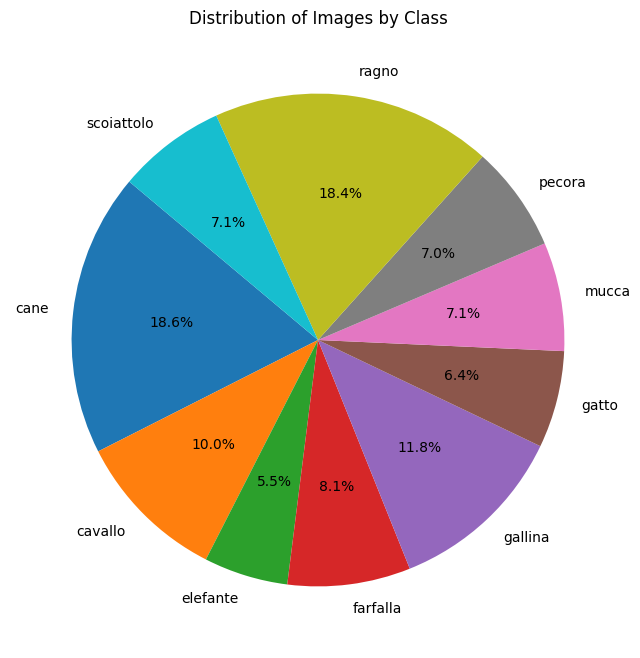

In [45]:
class_counts = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    image_count = len(images)
    class_counts[cls] = image_count

class_counts = dict(sorted(class_counts.items()))

plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Images by Class")
plt.show()

Також якщо дивитися на розподіл класів котрий не є збалансованим в немодифікованому датасеті, то важко прослідкувати коореляцію з вихідними результатами моделі, ragno має велику вибірку зображень, але elefante найбільш малочисленний клас. Якщо використовувати датасет на прикладних задачах, то обов'язково треба приділити увагу балансу класів, але на попередньо навчену модель це не повпливало.

- **Модель працює дуже добре (98% точності).**
- **Немає явного перенавчання, хоча результати натякають на нього.**
- **Можна покращити класифікацію для малочисленних класів** "pecora" і "farfalla".
- **Також варто збалансувати інші класи**, щоб покращити використання моделі в практичних задачах.
